In [26]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import matplotlib.dates as mdates

In [11]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

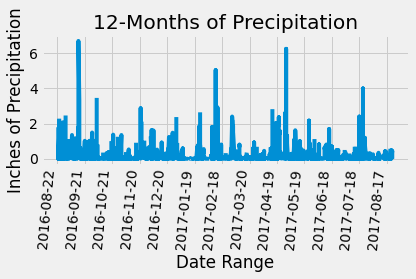

In [28]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
target_date = dt.date(2017, 8, 23)
delta = dt.timedelta(days=365)
query_date = target_date - delta

# Perform a query to retrieve the data and precipitation scores
precip = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_date).order_by(Measurement.date.desc()).all()
precip

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip, columns=['Date', 'Precipitation'])
precip_df.head()
precip_df.set_index('Date')

# Sort the dataframe by date
precip_df_by_date = precip_df.sort_values(by='Date')
precip_df_by_date.head()

# Use Pandas Plotting with Matplotlib to plot the data
dates = precip_df_by_date['Date']
x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
y = precip_df_by_date['Precipitation']

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.plot(x,y)
plt.gcf().autofmt_xdate()
plt.title('12-Months of Precipitation')
plt.xticks(rotation=85)
plt.xlabel('Date Range')
plt.ylabel('Inches of Precipitation')

plt.tight_layout()
plt.savefig('Images/12_Months_Precip.png')
plt.show()

In [29]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df_by_date.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [31]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.id).count()
print(f"The number of stations are: {stations}")

The number of stations are: 9


In [37]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station))\
                    .group_by(Measurement.station)\
                    .order_by(func.count(Measurement.station).desc())\
                    .statement
print(f"The most active stations are:")

active_stations_df = pd.read_sql_query(active_stations, session.bind)
active_stations_df

The most active stations are:


,station,count_1
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [46]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

most_active = session.query(func.min(Measurement.tobs),
                           func.max(Measurement.tobs),
                           func.avg(Measurement.tobs))\
                            .filter(Measurement.station == 'USC00519281')\
                            .all()

print(f"The most active station is Station ID - USC00519281.")
print(f"Temperature records for the most active station are:")
print(f"Lowest Recorded Temperature:", most_active[0][0])
print(f"Highest Recorded Temperature:", most_active[0][1])
print(f"Average Recorded Temperature:", most_active[0][2])

The most active station is Station ID - USC00519281.
Temperature records for the most active station are:
Lowest Recorded Temperature: 54.0
Highest Recorded Temperature: 85.0
Average Recorded Temperature: 71.66378066378067


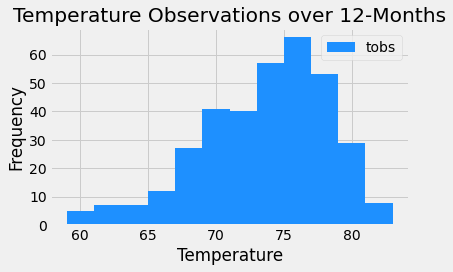

In [56]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

target_date = dt.date(2017, 8, 23)
delta = dt.timedelta(days=365)
query_date = target_date - delta

tobs_query = session.query(Measurement.tobs)\
    .filter(Measurement.station == 'USC00519281')\
    .filter(Measurement.date >= query_date)\
    .statement
tobs_query

tobs_query_df = pd.read_sql_query(tobs_query, session.bind)
tobs_query_df

observation = tobs_query_df.plot.hist(title="Temperature Observations over 12-Months", color="dodgerblue", bins=12)
observation.set_xlabel('Temperature')

plt.tight_layout()
plt.savefig("Images/temp_observe.png")
plt.show()

## Bonus Challenge Assignment

In [57]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [59]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

trip_temps = calc_temps('2016-02-28', '2016-03-05') 
print(trip_temps)

[(62.0, 69.88636363636364, 80.0)]


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
